# Land Cover

Gets MODIS, NLCD, and performs the crosswalk

In [1]:
%matplotlib ipympl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [4]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
import pickle
import shapely
import pandas as pd
import geopandas as gpd
import xarray as xr
pd.options.display.max_columns = None

import cftime
import datetime

import watershed_workflow 
import watershed_workflow.config
import watershed_workflow.sources
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.land_cover_properties
import watershed_workflow.io

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)

## Input: Parameters and other source data

In [5]:
# Force Watershed Workflow to pull data from this directory rather than a shared data directory.
# This picks up the Coweeta-specific datasets set up here to avoid large file downloads for 
# demonstration purposes.
#
def splitPathFull(path):
    """
    Splits an absolute path into a list of components such that
    os.path.join(*splitPathFull(path)) == path
    """
    parts = []
    while True:
        head, tail = os.path.split(path)
        if head == path:  # root on Unix or drive letter with backslash on Windows (e.g., C:\)
            parts.insert(0, head)
            break
        elif tail == path:  # just a single file or directory
            parts.insert(0, tail)
            break
        else:
            parts.insert(0, tail)
            path = head
    return parts

cwd = splitPathFull(os.getcwd())
assert cwd[-1] == 'workflow'
cwd = cwd[:-1]

# Note, this directory is where downloaded data will be put as well
data_dir = os.path.join(*(cwd + ['input_data',]))
def toInput(filename):
    return os.path.join(data_dir, filename)

output_filenames = dict()
output_dir = os.path.join(*(cwd + ['output_data',]))
def fromOutput(filename):
    return os.path.join(output_dir, filename)    

def toOutput(role, filename):
    output_filenames[role] = filename
    return fromOutput(filename)

# check output and input dirs exist
if not os.path.isdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir, exist_ok=True)
       

In [6]:
# Set the data directory to the local space to get the locally downloaded files
# REMOVE THIS CELL for general use outside fo Coweeta
watershed_workflow.config.setDataDirectory(data_dir)


In [7]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
name = 'RussianRiver'
hucs = ['18010110'] # a list of HUCs to run

# Geometric parameters
# -- parameters to clean and reduce the river network prior to meshing
prune_by_area = 10               # km^2
simplify = 125                   # length scale to target average edge 

# -- mesh triangle refinement control
refine_d0 = 200
refine_d1 = 600

refine_L0 = 125
refine_L1 = 300

refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

# Refine triangles if they get too acute
min_angle = 20 # degrees

# width of reach by stream order (order:width)
river_widths = dict({1:10, 2:10, 3:20, 4:30, 5:30}) 


# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.default_crs


# start and stop time for simulation
# note that this is the overlap of AORC and MODIS
start = cftime.DatetimeGregorian(2007, 8, 1)
end = cftime.DatetimeGregorian(2020, 7, 31)

start_noleap = cftime.DatetimeNoLeap(2007, 8, 1)
end_noleap = cftime.DatetimeNoLeap(2020, 7, 31)
cyclic_nyears = 10


In [8]:
# set up a dictionary of source objects
#
# Data sources, also called managers, deal with downloading and parsing data files from a variety of online APIs.
sources = watershed_workflow.sources.getDefaultSources()

# log the sources that will be used here
watershed_workflow.sources.logSources(sources)


2025-10-06 15:04:20,722 - root - INFO: Using sources:
2025-10-06 15:04:20,723 - root - INFO: --------------
2025-10-06 15:04:20,723 - root - INFO: HUC: WBD
2025-10-06 15:04:20,724 - root - INFO: hydrography: NHDPlus MR v2.1
2025-10-06 15:04:20,724 - root - INFO: DEM: 3DEP 60m
2025-10-06 15:04:20,724 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-10-06 15:04:20,724 - root - INFO: geologic structure: shapefile: "GLHYMPS.shp"
2025-10-06 15:04:20,725 - root - INFO: land cover: NLCD 2021 L48
2025-10-06 15:04:20,725 - root - INFO: LAI: MODIS
2025-10-06 15:04:20,725 - root - INFO: depth to bedrock: raster: "average_soil_and_sedimentary-deposit_thickness.tif"
2025-10-06 15:04:20,725 - root - INFO: meteorology: AORC v1.1


## Reload data

In [9]:
with open(fromOutput('02_watersheds.pickle'), 'rb') as fid:
    watersheds = pickle.load(fid)

In [10]:
with open(fromOutput('03_m2.pickle'), 'rb') as fid:
    m2 = pickle.load(fid)


In [11]:
for ls in m2.labeled_sets:
    print(f'"{ls.name}" : {ls.setid} consists of {len(ls.ent_ids)} {ls.entity}s')

"RR-outlet" : 10000 consists of 14831 CELLs
"RR-outlet surface" : 10001 consists of 14831 CELLs
"USGS-11467000" : 10002 consists of 13951 CELLs
"USGS-11467000 surface" : 10003 consists of 13951 CELLs
"USGS-11464000" : 10004 consists of 11214 CELLs
"USGS-11464000 surface" : 10005 consists of 11214 CELLs
"USGS-11463682" : 10006 consists of 4658 CELLs
"USGS-11463682 surface" : 10007 consists of 4658 CELLs
"USGS-11463500" : 10008 consists of 10254 CELLs
"USGS-11463500 surface" : 10009 consists of 10254 CELLs
"USGS-11463000" : 10010 consists of 22921 CELLs
"USGS-11463000 surface" : 10011 consists of 22921 CELLs
"USGS-11462500" : 10012 consists of 12109 CELLs
"USGS-11462500 surface" : 10013 consists of 12109 CELLs
"USGS-11462080" : 10014 consists of 16168 CELLs
"USGS-11462080 surface" : 10015 consists of 16168 CELLs
"USGS-11465350" : 10016 consists of 6050 CELLs
"USGS-11465350 surface" : 10017 consists of 6050 CELLs
"USGS-11465240" : 10018 consists of 1683 CELLs
"USGS-11465240 surface" : 100

## Get NLCD data

In [12]:
# download the NLCD raster
nlcd = sources['land cover'].getDataset(watersheds.exterior, watersheds.crs)['cover']

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
logging.info('Found land cover types: {}'.format(set(list(nlcd.values.ravel()))))

2025-10-06 15:04:21,130 - root - INFO: Incoming shape area = 0.39872864798547364
2025-10-06 15:04:21,131 - root - INFO: ... buffering incoming shape by = 0.00027
2025-10-06 15:04:21,132 - root - INFO: ... buffered shape area = 0.3999538760640716
2025-10-06 15:04:21,676 - root - INFO: Found land cover dtypes: uint8
2025-10-06 15:04:22,045 - root - INFO: Found land cover types: {np.uint8(71), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(11), np.uint8(81), np.uint8(82), np.uint8(52), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(90), np.uint8(31), np.uint8(95), np.uint8(127)}


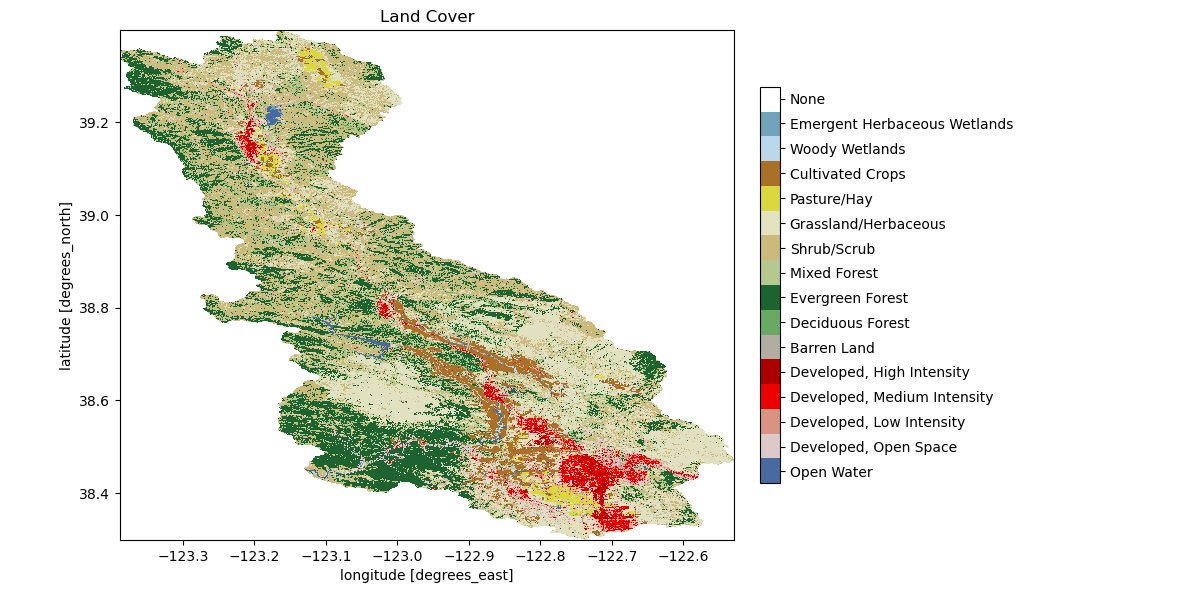

In [13]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))

fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0.1, 0.1, 0.55, 0.85])

nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, norm=nlcd_norm, ax=ax) 
ax.set_title('Land Cover')
plt.show()


In [14]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data['land_cover'] = m2_nlcd


In [15]:
# double-check that nan not in the values
assert 127 not in m2_nlcd

# create a new set of labels and indices with only those that actually appear on the mesh
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(m2_nlcd))

In [16]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [17]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 14831 : "RR-outlet"
10001 : CELL : 14831 : "RR-outlet surface"
10002 : CELL : 13951 : "USGS-11467000"
10003 : CELL : 13951 : "USGS-11467000 surface"
10004 : CELL : 11214 : "USGS-11464000"
10005 : CELL : 11214 : "USGS-11464000 surface"
10006 : CELL : 4658 : "USGS-11463682"
10007 : CELL : 4658 : "USGS-11463682 surface"
10008 : CELL : 10254 : "USGS-11463500"
10009 : CELL : 10254 : "USGS-11463500 surface"
10010 : CELL : 22921 : "USGS-11463000"
10011 : CELL : 22921 : "USGS-11463000 surface"
10012 : CELL : 12109 : "USGS-11462500"
10013 : CELL : 12109 : "USGS-11462500 surface"
10014 : CELL : 16168 : "USGS-11462080"
10015 : CELL : 16168 : "USGS-11462080 surface"
10016 : CELL : 6050 : "USGS-11465350"
10017 : CELL : 6050 : "USGS-11465350 surface"
10018 : CELL : 1683 : "USGS-11465240"
10019 : CELL : 1683 : "USGS-11465240 surface"
10020 : CELL : 18417 : "USGS-11466800"
10021 : CELL : 18417 : "USGS-11466800 surface"
10022 : CELL : 4810 : "USGS-11465200"
10023 : CELL : 4810 : "USGS-11

In [18]:
# write the mesh to disk with new NLCD labels
with open(toOutput('m2', '04_m2.pickle'), 'wb') as fid:
    pickle.dump(m2, fid)


## MODIS LAI

Leaf area index is needed on each land cover type -- this is used in the Evapotranspiration calculation.

### Download

In [19]:
# download LAI and corresponding LULC datasets -- these are actually already downloaded, 
# as the MODIS AppEEARS API is quite slow
#
# get the full LAI record
#req = sources['LAI'].requestDataset(watersheds.exterior, crs, task_id='29411e08-5863-48c0-8b86-84e44334b846')
req = sources['LAI'].requestDataset(watersheds.exterior, crs)

2025-10-06 15:04:23,388 - root - INFO: Incoming shape area = 0.3987281183568149
2025-10-06 15:04:23,388 - root - INFO: ... buffering incoming shape by = 0.0045000000000000005
2025-10-06 15:04:23,390 - root - INFO: ... buffered shape area = 0.4188010573075438
2025-10-06 15:04:23,391 - root - INFO: Building request for bounds: [np.float64(-123.392), np.float64(38.2948), np.float64(-122.5251), np.float64(39.4035)]
2025-10-06 15:04:23,391 - root - INFO: ... requires files:
2025-10-06 15:04:23,391 - root - INFO:  ... /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/input_data/land_cover/MODIS/modis_LAI_07-01-2002_01-01-2021_39.4035x-123.3920_38.2948x-122.5251.nc
2025-10-06 15:04:23,392 - root - INFO:  ... /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/input_data/land_cover/MODIS/modis_LULC_07-01-2002_01-01-2021_39.4035x-123.3920_38.2948x-122.5251.nc
2025-10-06 15:04:23,392 - root - INFO: ... files exist locally.


In [20]:
sources['LAI'].isReady(req)

True

In [21]:
modis_data = sources['LAI'].fetchRequest(req)

### Process

In [22]:
# MODIS data comes with time-dependent LAI AND time-dependent LULC -- just take the mode to find the most common LULC
modis_data['LULC'] = watershed_workflow.data.computeMode(modis_data['LULC'], 'time_LULC')

# now it is safe to have only one time
modis_data = modis_data.rename({'time_LAI':'time'})

# remove leap day (366th day of any leap year) to use a Noleap Calendar
modis_data = watershed_workflow.data.filterLeapDay(modis_data)

In [23]:
# plot the MODIS data
modis_data['LULC'].plot.imshow()

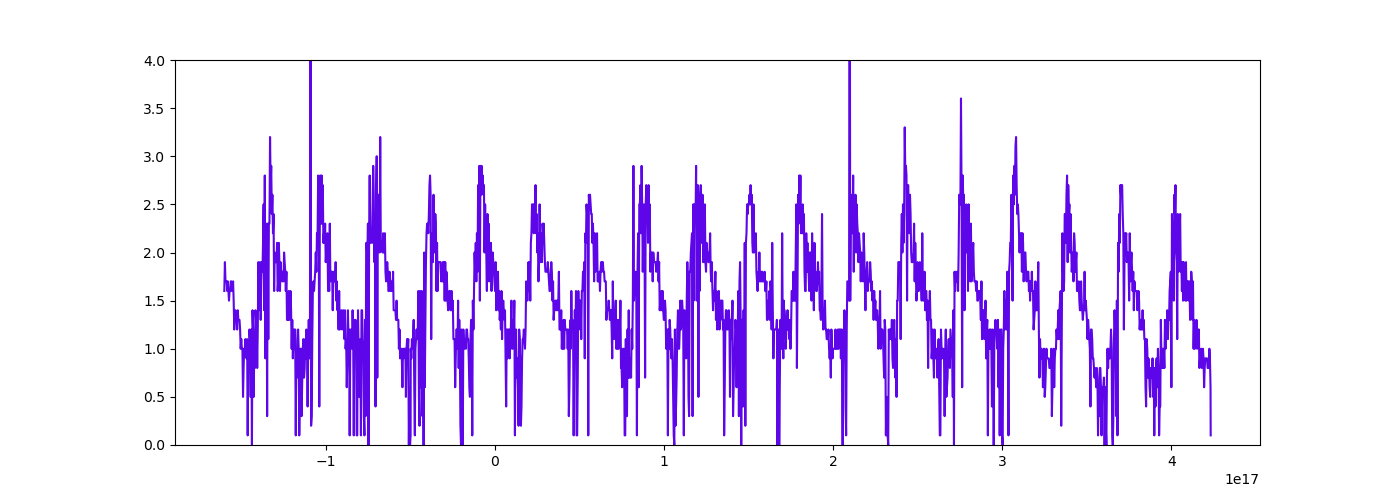

In [24]:
fig, ax = plt.subplots(figsize=(14,5))

time_xax = modis_data['time'] - start_noleap
ax.plot(time_xax, modis_data['LAI'][:, 18, 21])

#ax.set_xlim(0, 365 * 86400 * 1e9) # to zoom in to one year, convert time to nano-seconds
ax.set_ylim(0,4)
plt.show()




In [25]:
# compute the transient time series by class
modis_lai_ts = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                          polygon=watersheds.exterior, polygon_crs=watersheds.crs)

# also just compute the mean value time series
modis_lai_domain_avg_ts = modis_data['LAI'].mean(dim=('lat', 'lon'))


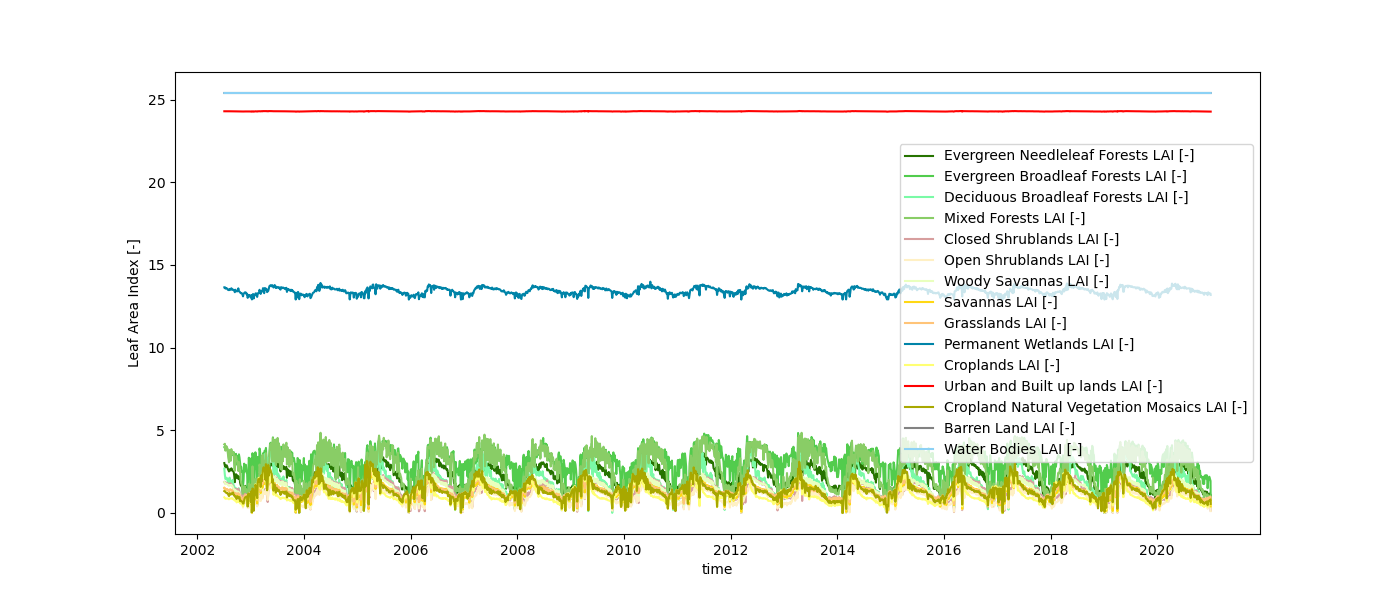

,Evergreen Needleleaf Forests LAI [-],Evergreen Broadleaf Forests LAI [-],Deciduous Broadleaf Forests LAI [-],Mixed Forests LAI [-],Closed Shrublands LAI [-],Open Shrublands LAI [-],Woody Savannas LAI [-],Savannas LAI [-],Grasslands LAI [-],Permanent Wetlands LAI [-],Croplands LAI [-],Urban and Built up lands LAI [-],Cropland Natural Vegetation Mosaics LAI [-],Barren Land LAI [-],Water Bodies LAI [-],time
0,3.019074,3.983299,2.684615,4.152055,1.874839,1.3650,1.876660,1.517177,1.509609,13.647541,0.948509,24.295205,1.324528,25.4,25.4,2002-07-04 00:00:00
1,2.852352,3.925624,2.284615,4.185616,1.890968,1.3200,1.839533,1.482583,1.494484,13.654098,0.898509,24.296842,1.311321,25.4,25.4,2002-07-08 00:00:00
2,2.763139,3.807286,2.053846,3.769863,1.765161,1.2450,1.745814,1.420316,1.436833,13.572131,0.862615,24.293918,1.264151,25.4,25.4,2002-07-12 00:00:00
3,2.873098,3.830495,2.100000,4.045890,1.809032,1.2700,1.777237,1.432613,1.436299,13.604918,0.871216,24.294503,1.228302,25.4,25.4,2002-07-16 00:00:00
4,2.883866,3.987065,2.130769,4.021918,1.812903,1.2900,1.770144,1.415517,1.450000,13.585246,0.869151,24.293567,1.200000,25.4,25.4,2002-07-20 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,1.161283,2.139828,0.784615,1.017123,0.740000,0.4200,0.690790,0.669806,0.893416,13.295082,0.618578,24.280234,0.726415,25.4,25.4,2020-12-19 00:00:00
1695,1.176057,2.190995,0.723077,0.941096,0.818710,0.4275,0.758405,0.741312,0.956050,13.270492,0.638647,24.280585,0.756604,25.4,25.4,2020-12-23 00:00:00
1696,1.158379,2.056365,0.892308,1.043151,0.794839,0.4575,0.734570,0.717556,0.948754,13.280328,0.710321,24.281053,0.769811,25.4,25.4,2020-12-27 00:00:00
1697,1.101452,1.938232,0.823077,1.010274,0.801935,0.4175,0.782873,0.780104,0.984875,13.265574,0.724427,24.280117,0.820755,25.4,25.4,2020-12-31 00:00:00


In [26]:
fig, ax = plt.subplots(figsize=(14,6))

watershed_workflow.land_cover_properties.plotLAI(modis_lai_ts, indices='MODIS', ax=ax)
ax.set_ylim(0,5)
ax.set_xlim(14534, 15000)
modis_lai_ts

### Evaluate simplified models of LAI relative to full spatial-temporal data

So the first question -- is the LAI well represented by just a time series and a LULC class?

Let's compute the class-averaged LAI time series, then compare each pixel to its class-average time series, and compute spatial and temporal patterns of RMSE.

In [27]:
# compute the error made by assuming LAI is represented by the class average
error = np.array([[modis_data['LAI'][:,i,j] - modis_lai_ts[watershed_workflow.sources.manager_modis_appeears.colors[int(modis_data['LULC'][i,j])][0] + ' LAI [-]'] for j in range(modis_data['LULC'].shape[1])] for i in range(modis_data['LULC'].shape[0])])


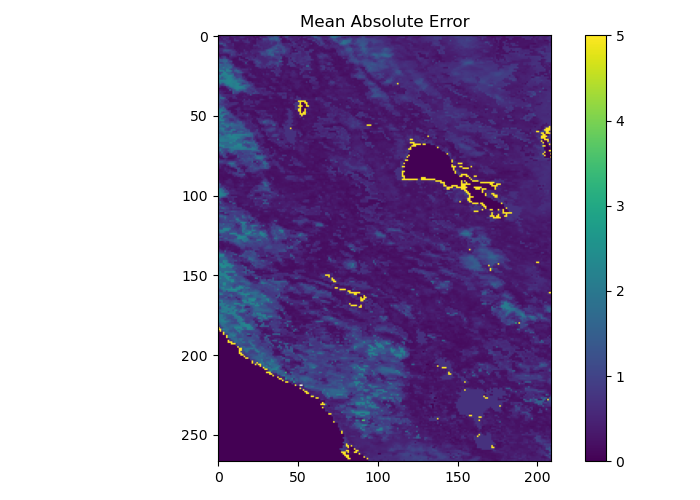

In [28]:
# Plot spatial MAE map
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(np.linalg.norm(error, ord=1, axis=2) / len(modis_lai_ts), cmap="viridis", vmax=5)
plt.colorbar(im)
ax.set_title("Mean Absolute Error")
plt.tight_layout()
plt.show()

In [29]:
# compute the error made by assuming LAI is constant across the domain
error_total = modis_data['LAI'] - modis_lai_domain_avg_ts

# this is the total variance of the LAI
V_total = (error_total**2).mean(dim=('lat','lon'))


In [30]:
# now compute the within-class variance
V_within  = xr.zeros_like(V_total)  # will accumulate within-class variance

# Fraction of pixels in each class
pixel_frac = modis_data['LULC'].groupby(modis_data['LULC']).count() / modis_data['LULC'].size # dict: class -> fraction

# Compute within-class variance at each time
for c in np.unique(modis_data['LULC']):
    mask = (modis_data['LULC'] == c)
    # mask LAI to only class c
    lai_c = modis_data['LAI'].where(mask)
    # compute variance over spatial dims (ignoring NaNs for masked pixels)
    var_c = lai_c.var(dim=('lat', 'lon'), skipna=True)
    # weight by pixel fraction
    frac_c = mask.sum() / mask.size
    V_within += frac_c * var_c

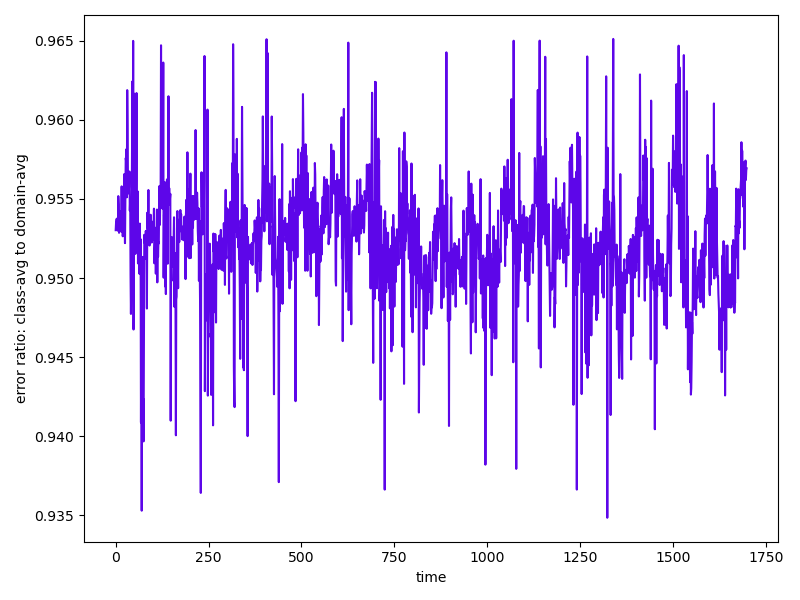

In [31]:
# plot temporal error ratio -- what is R2 of the ratio of within-class variance to total variance?
r2 = 1 - V_within / V_total

fig,ax = plt.subplots()
ax.plot(r2)
ax.set_xlabel('time')
ax.set_ylabel('error ratio: class-avg to domain-avg')
plt.tight_layout()
plt.show()

It looks like class-based is a reasonable choice for this domain -- the within-class variance is MUCH smaller than the total variance

This convinces us that class-based LAI is good enough.

### Continue to process and write to disk

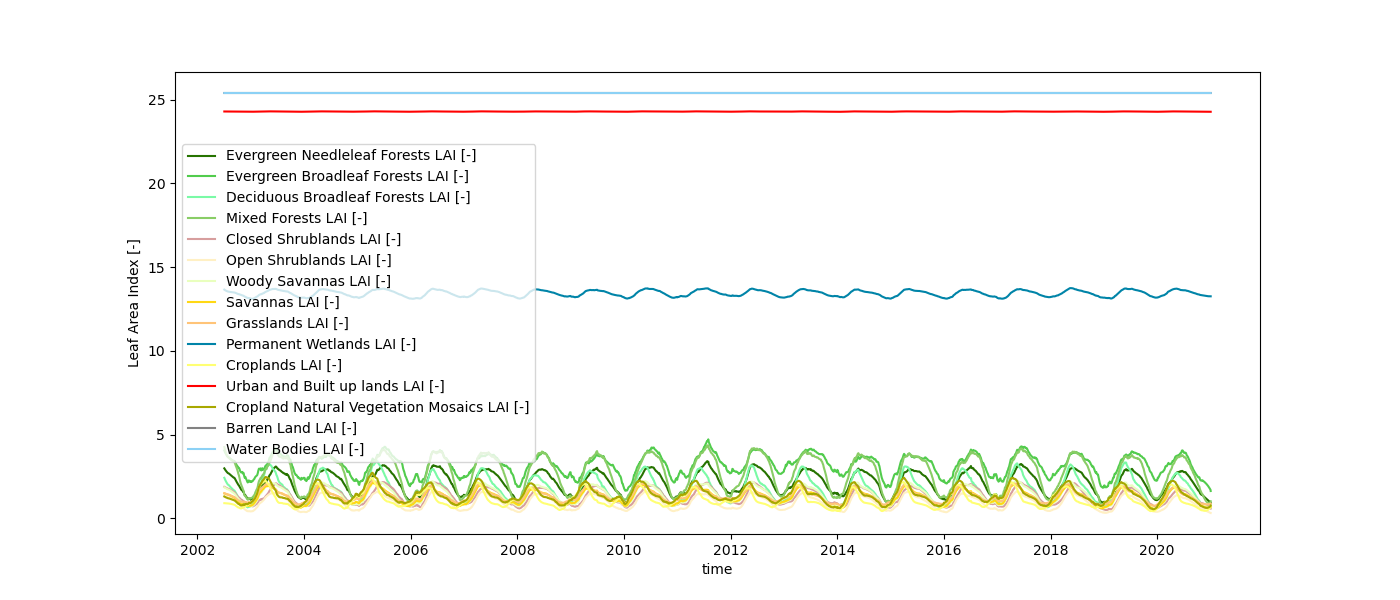

(14534, 15000)

In [32]:
# smooth the data in time
modis_lai_smoothed = watershed_workflow.data.smoothTimeSeries(modis_lai_ts, 'time', window_length=31)

fig, ax = plt.subplots(figsize=(14,6))
watershed_workflow.land_cover_properties.plotLAI(modis_lai_smoothed, indices='MODIS', ax=ax)
ax.set_ylim(0,5)
ax.set_xlim(14534, 15000)

In [33]:
# compute a typical year
modis_lai_typical = watershed_workflow.data.computeAverageYear(modis_lai_smoothed,
                                                              start_date = start_noleap - datetime.timedelta(days=365*cyclic_nyears),
                                                              output_nyears=cyclic_nyears, 
                                                              )

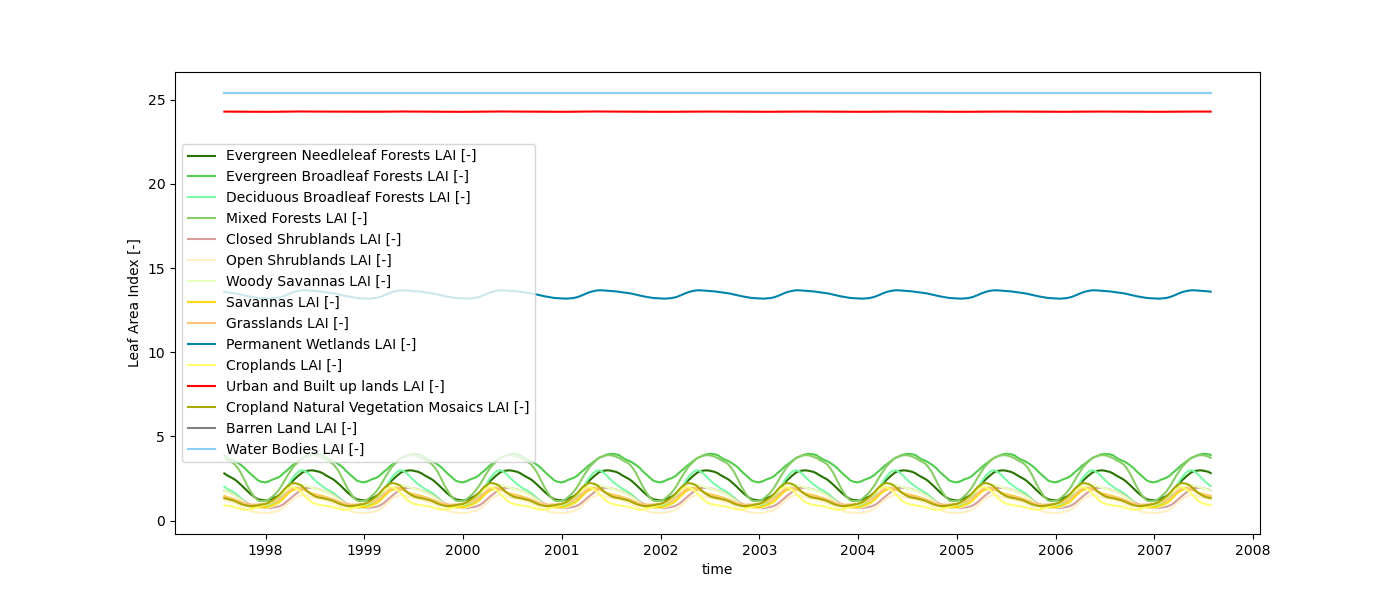

,time,Evergreen Needleleaf Forests LAI [-],Evergreen Broadleaf Forests LAI [-],Deciduous Broadleaf Forests LAI [-],Mixed Forests LAI [-],Closed Shrublands LAI [-],Open Shrublands LAI [-],Woody Savannas LAI [-],Savannas LAI [-],Grasslands LAI [-],Permanent Wetlands LAI [-],Croplands LAI [-],Urban and Built up lands LAI [-],Cropland Natural Vegetation Mosaics LAI [-],Barren Land LAI [-],Water Bodies LAI [-]
0,1997-08-01 00:00:00,2.798880,3.886611,2.013172,3.712133,1.780331,1.229711,1.769366,1.454921,1.420716,13.591439,0.908018,24.294562,1.331406,25.4,25.4
1,1997-08-05 00:00:00,2.751481,3.826318,1.964750,3.661922,1.751168,1.211341,1.737673,1.430327,1.402033,13.578684,0.894801,24.294091,1.309192,25.4,25.4
2,1997-08-09 00:00:00,2.710823,3.779751,1.914585,3.619578,1.724936,1.193371,1.709830,1.409599,1.385403,13.567990,0.884648,24.293683,1.293826,25.4,25.4
3,1997-08-13 00:00:00,2.673989,3.738291,1.881514,3.581316,1.700402,1.177334,1.684368,1.390530,1.369971,13.559644,0.875617,24.293306,1.279082,25.4,25.4
4,1997-08-17 00:00:00,2.639298,3.700560,1.845637,3.555952,1.676234,1.159498,1.658880,1.371748,1.355081,13.552073,0.867756,24.292938,1.266149,25.4,25.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,2007-07-12 00:00:00,2.922457,3.948906,2.254973,3.831461,1.881743,1.304843,1.867870,1.529565,1.488725,13.623203,0.957421,24.295925,1.386792,25.4,25.4
916,2007-07-16 00:00:00,2.906694,3.943206,2.202239,3.814630,1.868750,1.293720,1.854228,1.517544,1.477121,13.617265,0.943577,24.295679,1.370385,25.4,25.4
917,2007-07-20 00:00:00,2.886597,3.938444,2.154017,3.795936,1.850655,1.280661,1.836404,1.503088,1.464080,13.612034,0.933133,24.295423,1.356952,25.4,25.4
918,2007-07-24 00:00:00,2.856459,3.915955,2.101992,3.762321,1.827254,1.264149,1.813721,1.486575,1.449764,13.603488,0.923099,24.295111,1.345232,25.4,25.4


In [34]:
fig, ax = plt.subplots(figsize=(14,6))
watershed_workflow.land_cover_properties.plotLAI(modis_lai_typical, indices='MODIS', ax=ax)
modis_lai_typical

In [35]:
# limit the raw data to the window we want
modis_lai_ts_limited = modis_lai_ts[(modis_lai_smoothed["time"] >= start_noleap) & (modis_lai_smoothed["time"] <= end_noleap)]

In [36]:
modis_lai_typical['time'].iloc[-1]

cftime.DatetimeNoLeap(2007, 7, 28, 0, 0, 0, 0, has_year_zero=True)

In [37]:
# save the two time series files -- modis data
fname_modis_lai_typical = toOutput('modis_lai_typical', f'RussianRiver_LAI_MODIS_CyclicSteadystate_{modis_lai_typical['time'].iloc[0].year}_{modis_lai_typical['time'].iloc[-1].year}.h5')
watershed_workflow.io.writeTimeseriesToHDF5(fname_modis_lai_typical, modis_lai_typical)

fname_modis_lai_ts = toOutput('modis_lai_ts', f'RussianRiver_LAI_MODIS_Transient_{modis_lai_ts_limited['time'].iloc[0].year}_{modis_lai_ts_limited['time'].iloc[-1].year}.h5')
watershed_workflow.io.writeTimeseriesToHDF5(fname_modis_lai_ts, modis_lai_ts_limited)


2025-10-06 15:04:49,696 - root - INFO: Writing HDF5 file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/output_data/RussianRiver_LAI_MODIS_CyclicSteadystate_1997_2007.h5
2025-10-06 15:04:49,701 - root - INFO: Writing HDF5 file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/output_data/RussianRiver_LAI_MODIS_Transient_2007_2020.h5


## Compute the crosswalk of NLCD and MODIS

This tells us how to map MODIS LAI onto NLCD classes.

2025-10-06 15:04:49,903 - root - INFO: Compute the crosswalk between MODIS and NLCD:
2025-10-06 15:04:49,903 - root - INFO:   unique MODIS: [np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(16.0), np.float64(17.0)]
2025-10-06 15:04:49,903 - root - INFO:   unique NLCD: [np.uint8(11), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(31), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(82), np.uint8(90), np.uint8(95)]


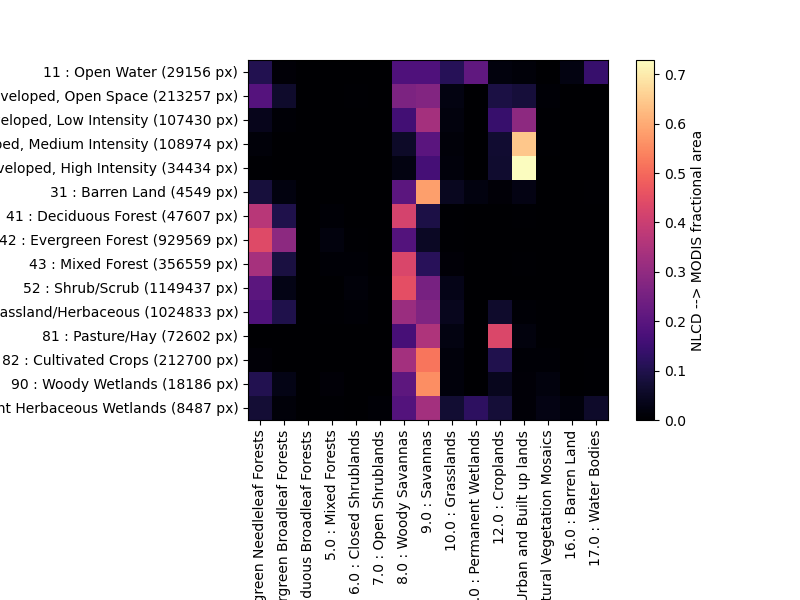

In [38]:
crosswalk = watershed_workflow.land_cover_properties.computeCrosswalk(modis_data['LULC'], nlcd, method='fractional area')

In [39]:
# Compute the NLCD-based time series
nlcd_lai_typical = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_typical)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_typical)


nlcd_lai_ts = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_ts_limited)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_ts)

nlcd_lai_ts

None LAI [-] False
Open Water LAI [-] True
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] True
Barren Land LAI [-] True
None LAI [-] False
Open Water LAI [-] True
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] True
Barren Land LAI [-] True


,time,Open Water LAI [-],"Developed, Open Space LAI [-]","Developed, Low Intensity LAI [-]","Developed, Medium Intensity LAI [-]","Developed, High Intensity LAI [-]",Barren Land LAI [-],Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Grassland/Herbaceous LAI [-],Pasture/Hay LAI [-],Cultivated Crops LAI [-],Woody Wetlands LAI [-],Emergent Herbaceous Wetlands LAI [-]
465,2007-08-01 00:00:00,0.0,3.610566,8.182459,0.0,0.0,0.0,2.327937,2.850276,2.266992,1.881052,2.114769,1.616067,1.710901,2.002477,4.971695
466,2007-08-05 00:00:00,0.0,3.703864,8.258306,0.0,0.0,0.0,2.437132,2.860968,2.381701,2.021808,2.208966,1.698753,1.841115,2.109103,5.061349
467,2007-08-09 00:00:00,0.0,3.564095,8.166968,0.0,0.0,0.0,2.253276,2.732043,2.196448,1.831656,2.057170,1.611256,1.686750,1.964593,4.942782
468,2007-08-13 00:00:00,0.0,3.581403,8.232487,0.0,0.0,0.0,2.216671,2.521475,2.178333,1.898752,2.066718,1.699165,1.817056,2.028419,5.011740
469,2007-08-17 00:00:00,0.0,3.525498,8.151245,0.0,0.0,0.0,2.193516,2.635347,2.141613,1.798694,2.013752,1.591268,1.674085,1.937178,4.925806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,2020-07-12 00:00:00,0.0,3.628951,8.181180,0.0,0.0,0.0,2.361126,2.949273,2.294150,1.881916,2.140400,1.618926,1.698676,2.007384,4.984854
1655,2020-07-16 00:00:00,0.0,3.634082,8.230213,0.0,0.0,0.0,2.323575,2.725242,2.274271,1.942385,2.133184,1.677840,1.804483,2.044981,5.015800
1656,2020-07-20 00:00:00,0.0,3.620615,8.188788,0.0,0.0,0.0,2.337170,2.879029,2.274066,1.880958,2.124249,1.630095,1.712946,2.010115,4.977364
1657,2020-07-24 00:00:00,0.0,3.702637,8.253520,0.0,0.0,0.0,2.432101,2.929172,2.373093,1.996093,2.216675,1.703278,1.824319,2.104204,5.053285


In [40]:
# save the two time series files -- NLCD data
fname_nlcd_lai_typical = toOutput('nlcd_lai_typical', f'RussianRiver_LAI_NLCD_CyclicSteadystate_{nlcd_lai_typical['time'].iloc[0].year}_{nlcd_lai_typical['time'].iloc[-1].year}.h5')
watershed_workflow.io.writeTimeseriesToHDF5(fname_nlcd_lai_typical, nlcd_lai_typical)


fname_nlcd_lai_ts = toOutput('nlcd_lai_ts', f'RussianRiver_LAI_NLCD_Transient_{nlcd_lai_ts['time'].iloc[0].year}_{nlcd_lai_ts['time'].iloc[-1].year}.h5')
watershed_workflow.io.writeTimeseriesToHDF5(fname_nlcd_lai_ts, nlcd_lai_ts)

2025-10-06 15:04:50,694 - root - INFO: Writing HDF5 file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/output_data/RussianRiver_LAI_NLCD_CyclicSteadystate_1997_2007.h5
2025-10-06 15:04:50,699 - root - INFO: Writing HDF5 file: /home/ecoon/research/HypeRFACETs/PacWest-RDT/RussianRiver/output_data/RussianRiver_LAI_NLCD_Transient_2007_2020.h5


In [41]:
# lastly, reread, update, and output filenames
with open(toOutput('04_output_filenames', '04_output_filenames.txt'), 'wb') as fid:
    pickle.dump(output_filenames, fid)
